**Purpose**: This notebook explores variable values for a given time period.

In [23]:
import intake
import numpy as np
import geopandas as gpd
import rioxarray
from dask.distributed import Client
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

import pandas
import datetime


# helper functions
import helpers

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/castronova/proxy/8787/status,
Dashboard: /user/castronova/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41961,Workers: 4
Dashboard: /user/castronova/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:39797,Total threads: 2
Dashboard: /user/castronova/proxy/40031/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:33691,


In [35]:
# HELPER FUNCTIONS

import textwrap
import warnings 
warnings.filterwarnings("ignore")

def analyze_data(variable='RAIN',
                 frequency='daily',
                 experiment='historical',
                 forcing_variant='cmip6',
                 start_date = '1861-01-01',
                 end_date = '1863-01-01',
                 rolling_window = 45,
                 ensemble_members=[0]):

    ######################
    ### LOAD CESM DATA ###
    ######################
    catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json')

    catalog_subset = catalog.search(variable=variable, frequency='daily')


    # return a dictionary of the datasets in the catalog_subset
    dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})
    
    # load the historical cmip predictions
    cesm_key = f'{catalog_subset.df.component.iloc[0]}.{experiment}.{frequency}.{forcing_variant}'
    historical_cmip6 = dsets[cesm_key]
    
    # set the SRS
    historical_cmip6.rio.write_crs("epsg:4326", inplace=True)
    historical_cmip6.rio.set_spatial_dims('lon', 'lat')
    historical_cmip6.rio.crs.to_wkt()
    
    # convert the longitudes in our dataset from degrees-west into degrees ranging from -180 to 180 
    # this is necessary so that they align properly with our vector data.
    historical_cmip6['lon'] = historical_cmip6.lon - 180

    ####################
    ### SPATIAL CLIP ###
    ####################
    
    # Load the sample dataset of the USA states from geopandas
    usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Filter the dataset for the USA
    usa_states = usa[usa['iso_a3'] == 'USA']
    
    # Load the US states from an online source
    states_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
    states = gpd.read_file(states_url)
    geom = states[states.name == 'Oregon']
    
    
    # clip the data
    cmip = historical_cmip6.rio.clip(
             geom.geometry.values,
             geom.crs,
             all_touched=True,   # select all grid cells that touch the vector boundary
             drop=True,          # drop anything that is outside the clipped region
             invert=False,
             from_disk=True)

    #######################
    ### CLIP TEMPORALLY ###
    #######################
    dat = cmip.sel(time=slice(start_date, end_date))

    long_name = dat.attrs['intake_esm_attrs:long_name']
    units = dat.attrs['intake_esm_attrs:units']

    ############################################################
    ### Compute Cumulative Rainfall for each Ensemble Member ###
    ############################################################
    
    # calcuate 45-day rolling windows for the first 10 ensemble members
    rolling_dict = helpers.compute_rolling_windows(dat, variable=variable, num_days=45, ensembles=ensemble_members, center=True)

    # convert time variable to a pandas datetimeindex
    for k, rolling_mem in rolling_dict.items():
        rolling_mem['time'] = rolling_mem.indexes['time'].to_datetimeindex()

    wrapped_label = textwrap.fill(f'{long_name} [{units}]', 30)
    helpers.create_rolling_window_plots(rolling_dict,
                                        title=f'{rolling_window}-day Rolling Window {variable}',
                                        ylabel=wrapped_label)

In [3]:
# List the data available in the Intake Catalog
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

for variable in catalog.df.variable.unique():
    dat = catalog.df.loc[catalog.df.variable == variable].head(1)
    try:
        print(f'{dat["variable"].item():<20} {dat["long_name"].item()}')
    except:
        pass

FLNS                 net longwave flux at surface
FLNSC                clearsky net longwave flux at surface
FLUT                 upwelling longwave flux at top of model
FSNS                 net solar flux at surface
FSNSC                clearsky net solar flux at surface
LHFLX                surface latent heat flux
PRECC                convective precipitation rate (liq + ice)
PRECL                large-scale (stable) precipitation rate (liq + ice)
PRECSC               convective snow rate (water equivalent)
PRECSL               large-scale (stable) snow rate (water equivalent)
PS                   surface pressure
PSL                  sea level pressure
Q                    specific humidity
SHFLX                surface sensible heat flux
T                    temperature
TMQ                  total (vertically integrated) precipitable water
TREFHT               reference height temperature
TREFHTMN             minimum reference height temperature over output period
TREFHTMX          

In [ ]:
analyze_data(variable='RAIN',
             frequency='daily',
             experiment='historical',
             forcing_variant='cmip6',
             start_date = '1861-01-01',
             end_date = '1863-01-01',
             rolling_window = 45,
             ensemble_members=range(0,10))



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


Processing Member 0...done
Processing Member 1...done
Processing Member 2...done
Processing Member 3...


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


Processing Member 0...done
Processing Member 1...done
Processing Member 2...done
Processing Member 3...done
Processing Member 4...done
Processing Member 5...done
Processing Member 6...done
Processing Member 7...done
Processing Member 8...done
Processing Member 9...done


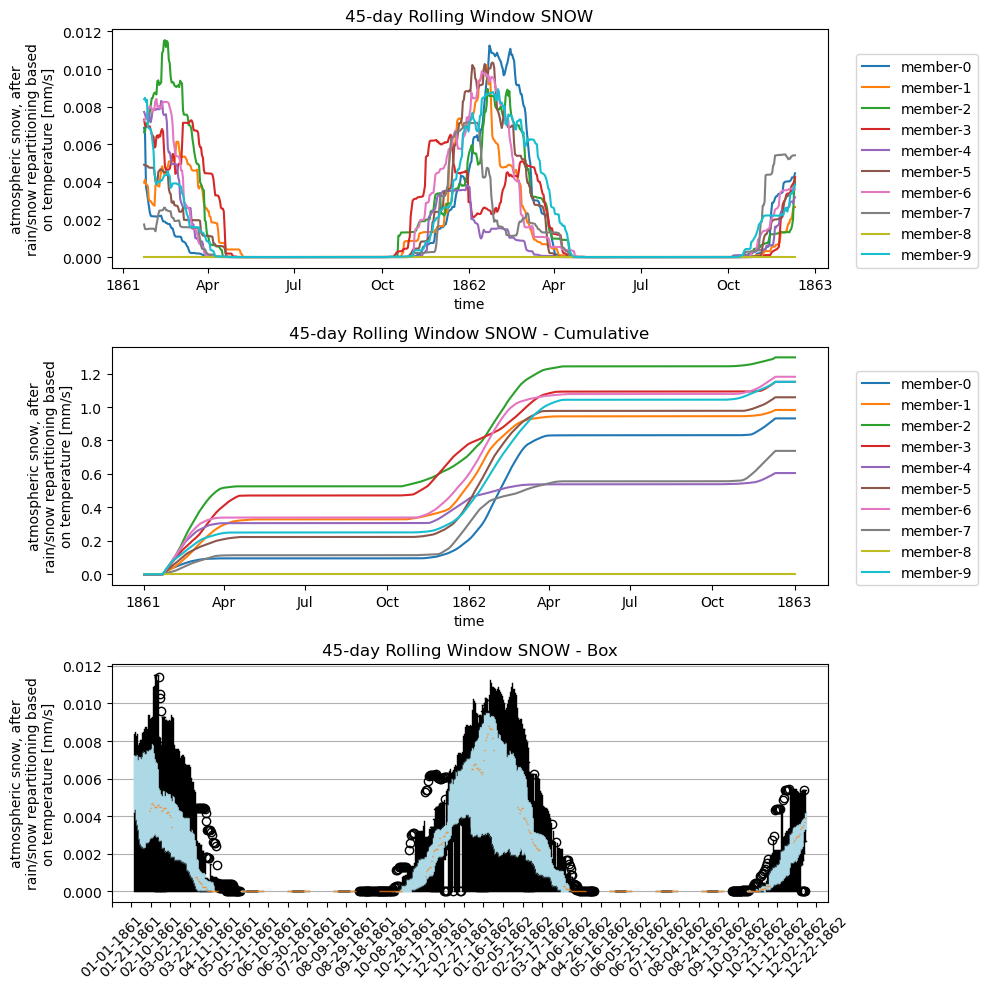

In [37]:
analyze_data(variable='SNOW',
             frequency='daily',
             experiment='historical',
             forcing_variant='cmip6',
             start_date = '1861-01-01',
             end_date = '1863-01-01',
             rolling_window = 45,
             ensemble_members=range(0, 10))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


Processing Member 0...done
Processing Member 1...done
Processing Member 2...done
Processing Member 3...done
Processing Member 4...done
Processing Member 5...done
Processing Member 6...done
Processing Member 7...done
Processing Member 8...done
Processing Member 9...done


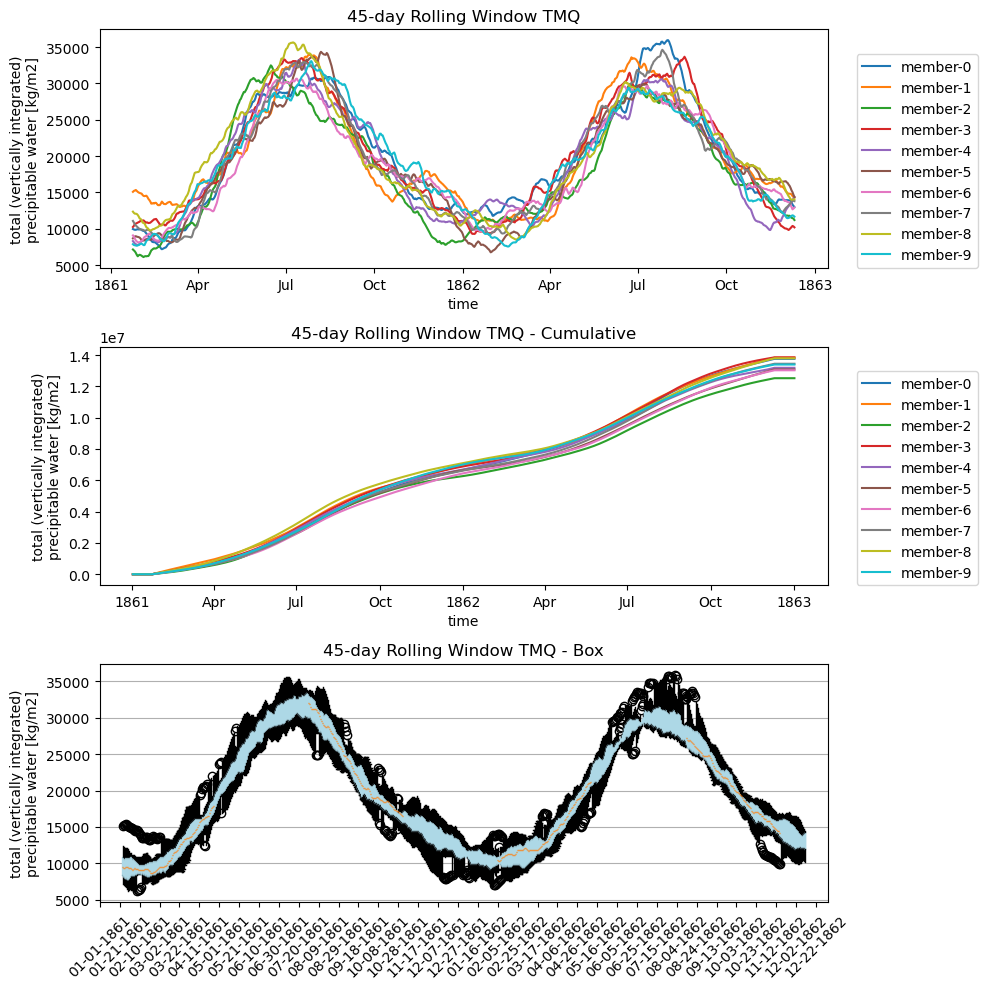

In [38]:
analyze_data(variable='TMQ',
             frequency='daily',
             experiment='historical',
             forcing_variant='cmip6',
             start_date = '1861-01-01',
             end_date = '1863-01-01',
             rolling_window = 45,
             ensemble_members=range(0, 10))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


Processing Member 0...done
Processing Member 1...done
Processing Member 2...done
Processing Member 3...done
Processing Member 4...done
Processing Member 5...done
Processing Member 6...done
Processing Member 7...done
Processing Member 8...done
Processing Member 9...done


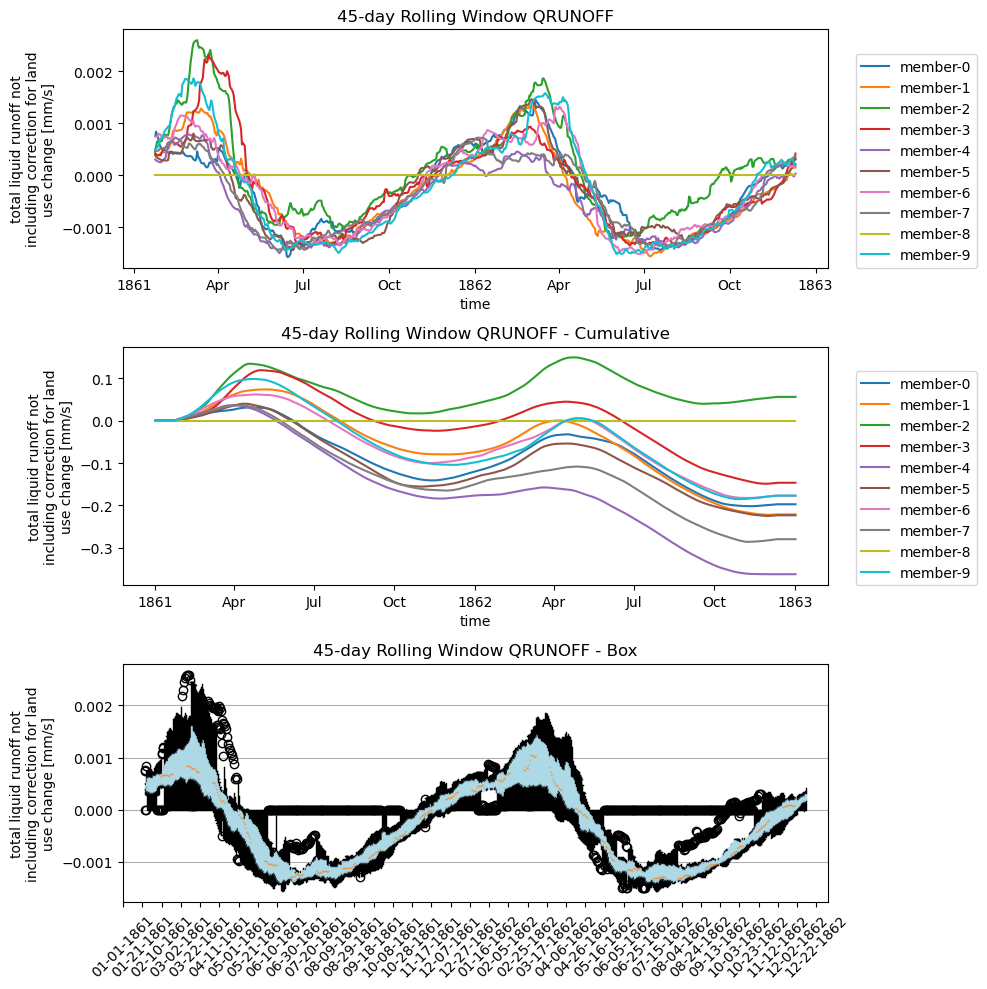

In [39]:
analyze_data(variable='QRUNOFF',
             frequency='daily',
             experiment='historical',
             forcing_variant='cmip6',
             start_date = '1861-01-01',
             end_date = '1863-01-01',
             rolling_window = 45,
             ensemble_members=range(0, 10))